In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc

In [2]:
df = pd.read_csv('datasets/processed_dataset.csv')
df = df.drop(columns=['Unnamed: 0'])

### Data splitting

In [3]:
random_seed = 47
x_train, x_test, y_train, y_test = train_test_split(df.drop(columns=['PumpFailed']), 
                                                df['PumpFailed'], test_size=0.3, random_state=random_seed)

In [4]:
print(f'Train df size, X: {x_train.shape}, Y: {y_train.shape}')
print(f'Test df size, X: {x_test.shape}, Y: {y_test.shape}')

Train df size, X: (18830, 387), Y: (18830,)
Test df size, X: (8070, 387), Y: (8070,)


Balance of classes:
0    16769
1     2061
Name: PumpFailed, dtype: int64


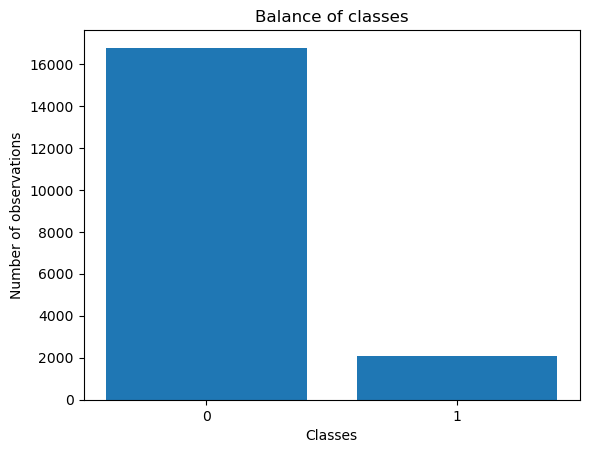

In [5]:
class_counts = y_train.value_counts()
print('Balance of classes:')
print(class_counts)

plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Classes')
plt.ylabel('Number of observations')
plt.title('Balance of classes')
plt.xticks([0, 1])
plt.show()

I'll try to balance the minority class using SMOTE.

### SMOTE
SMOTE (Synthetic Minority Over-sampling Technique) is one of the most common methods to remove unbalanced data. This method generates synthetic samples in a minority class.

* SMOTE cannot be used if there are nan values in the dataset, so I replaced them with -9999.
* I also replaced nan values with -9999 for the test set, as Log Reg can not handle nans.

In [6]:
x_train = x_train.fillna(-9999)
x_test = x_test.fillna(-9999)

In [7]:
sm = SMOTE(sampling_strategy='minority', random_state=42)
x_train_resampled, y_train_resampled = sm.fit_resample(x_train, y_train)

Balance of classes:
0    16769
1    16769
Name: PumpFailed, dtype: int64


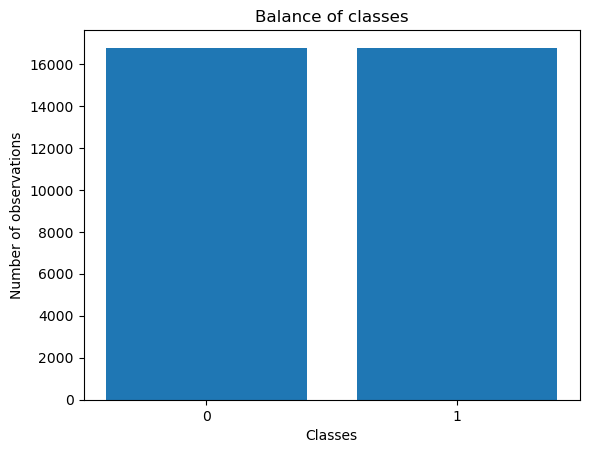

In [8]:
class_counts = y_train_resampled.value_counts()
print('Balance of classes:')
print(class_counts)

plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Classes')
plt.ylabel('Number of observations')
plt.title('Balance of classes')
plt.xticks([0, 1])
plt.show()

### Feature Scaling

In [9]:
columns_to_scale = ['mean_pressure_first_half', 'median_pressure_first_half', 'max_pressure_first_half', 
                    'max_diff_first_half', 'mean_pressure_second_half', 'median_pressure_second_half', 
                    'max_pressure_second_half', 'std_pressure_second_half', 'max_diff_second_half']

x_train_resampled_norm = x_train_resampled.copy()
x_train_norm = x_train.copy()
x_test_norm = x_test.copy()

scaler_norm = MinMaxScaler()
x_train_resampled_norm[columns_to_scale] = scaler_norm.fit_transform(x_train_resampled[columns_to_scale])
x_train_norm[columns_to_scale] = scaler_norm.fit_transform(x_train[columns_to_scale])
x_test_norm[columns_to_scale] = scaler_norm.transform(x_test[columns_to_scale])

In [10]:
x_train_resampled_std = x_train_resampled.copy()
x_train_std = x_train.copy()
x_test_std = x_test.copy()

scaler_std = StandardScaler()
x_train_resampled_std[columns_to_scale] = scaler_std.fit_transform(x_train_resampled[columns_to_scale])
x_train_std[columns_to_scale] = scaler_std.fit_transform(x_train[columns_to_scale])
x_test_std[columns_to_scale] = scaler_std.transform(x_test[columns_to_scale])

### Modeling 
Normalized data

In [11]:
start = time.time()

logreg_norm = LogisticRegression(solver='liblinear', C=0.01, max_iter=5000)
logreg_norm.fit(x_train_resampled, y_train_resampled)

time_in_minutes = round((time.time() - start) / 60, 1)
print('All done. This operation took', time_in_minutes, 'minutes.')

All done. This operation took 0.0 minutes.


#### Metrics

In [12]:
y_pred_logreg_norm_train = logreg_norm.predict(x_train_resampled_norm)
print('Classification report for training set:')
print(classification_report(y_train_resampled, y_pred_logreg_norm_train))

Classification report for training set:
              precision    recall  f1-score   support

           0       0.81      0.87      0.84     16769
           1       0.86      0.80      0.83     16769

    accuracy                           0.83     33538
   macro avg       0.84      0.83      0.83     33538
weighted avg       0.84      0.83      0.83     33538



In [13]:
y_pred_logreg_norm_test = logreg_norm.predict(x_test_norm)
print('Classification report for testing set:')
print(classification_report(y_test, y_pred_logreg_norm_test))

Classification report for testing set:
              precision    recall  f1-score   support

           0       0.96      0.87      0.91      7189
           1       0.40      0.71      0.51       881

    accuracy                           0.85      8070
   macro avg       0.68      0.79      0.71      8070
weighted avg       0.90      0.85      0.87      8070



### TEST with `class_weight`

In [14]:
start = time.time()

logreg_norm = LogisticRegression(solver='liblinear', C=0.01, max_iter=5000, class_weight='balanced')
logreg_norm.fit(x_train_norm, y_train)

time_in_minutes = round((time.time() - start) / 60, 1)
print('All done. This operation took', time_in_minutes, 'minutes.')

All done. This operation took 0.0 minutes.


In [15]:
y_pred_logreg_norm_train = logreg_norm.predict(x_train_norm)
print('Classification report for training set:')
print(classification_report(y_train, y_pred_logreg_norm_train))

Classification report for training set:
              precision    recall  f1-score   support

           0       0.98      0.83      0.90     16769
           1       0.39      0.88      0.54      2061

    accuracy                           0.84     18830
   macro avg       0.69      0.86      0.72     18830
weighted avg       0.92      0.84      0.86     18830



In [16]:
y_pred_logreg_norm_test = logreg_norm.predict(x_test_norm)
print('Classification report for testing set:')
print(classification_report(y_test, y_pred_logreg_norm_test))

Classification report for testing set:
              precision    recall  f1-score   support

           0       0.98      0.83      0.90      7189
           1       0.39      0.87      0.53       881

    accuracy                           0.83      8070
   macro avg       0.68      0.85      0.72      8070
weighted avg       0.92      0.83      0.86      8070



### Modeling
Standardized data

In [17]:
start = time.time()

logreg_std = LogisticRegression(solver='liblinear', C=0.001, max_iter=5000)
logreg_std.fit(x_train_resampled_std, y_train_resampled)

time_in_minutes = round((time.time() - start) / 60, 1)
print('All done. This operation took', time_in_minutes, 'minutes.')

All done. This operation took 0.0 minutes.


#### Metrics

In [18]:
y_pred_logreg_std_train = logreg_std.predict(x_train_resampled_std)
print('Classification report for training set:')
print(classification_report(y_train_resampled, y_pred_logreg_std_train))

Classification report for training set:
              precision    recall  f1-score   support

           0       0.82      0.85      0.83     16769
           1       0.84      0.82      0.83     16769

    accuracy                           0.83     33538
   macro avg       0.83      0.83      0.83     33538
weighted avg       0.83      0.83      0.83     33538



In [19]:
y_pred_logreg_std_test = logreg_std.predict(x_test_std)
print('Classification report for testing set:')
print(classification_report(y_test, y_pred_logreg_std_test))

Classification report for testing set:
              precision    recall  f1-score   support

           0       0.98      0.85      0.91      7189
           1       0.40      0.82      0.53       881

    accuracy                           0.84      8070
   macro avg       0.69      0.83      0.72      8070
weighted avg       0.91      0.84      0.87      8070



When normalizing and standardizing the data, the results of model predictions are not significantly different.

#### `Precision` shows how much we can trust the model's predictions when it says that an object belongs to a certain class. 
#### `Recall` shows how well the model can identify all objects of a particular class. 


`Standardization` puts the data into a form where it has a mean equal to 0 and a standard deviation equal to 1. This is useful when the data is normally distributed, but in practice it can work quite well even for data that does not follow an exactly normal distribution. This is usually more versatile than normalization and is the preferred method for many machine learning techniques, including linear and logistic regression. 

### Hyperparameters Optimization 

In [20]:
start = time.time()

logreg = LogisticRegression(max_iter=5000)

param_grid_logreg_liblinear = [
    {
     'solver': ['liblinear'],
     'penalty': ['l1', 'l2'],
     'C': [0.001, 0.01, 0.1, 1]}
]

grid_count_logreg_liblinear = ParameterGrid(param_grid_logreg_liblinear)
print('Total combinations of parameters: ', len(grid_count_logreg_liblinear))

grid_search_logreg_liblinear = GridSearchCV(logreg, param_grid=param_grid_logreg_liblinear, cv=5, scoring='f1', n_jobs=-1)
grid_search_logreg_liblinear.fit(x_train_resampled_std, y_train_resampled)

time_in_minutes = round((time.time() - start) / 60, 1)
print('All done. This operation took', time_in_minutes, 'minutes.')

Total combinations of parameters:  8
All done. This operation took 0.1 minutes.


In [21]:
print('Classification report for training set:')
y_pred_logreg_grid_train = grid_search_logreg_liblinear.predict(x_train_resampled_std)
print(classification_report(y_train_resampled, y_pred_logreg_grid_train))

Classification report for training set:
              precision    recall  f1-score   support

           0       0.95      0.91      0.93     16769
           1       0.91      0.96      0.93     16769

    accuracy                           0.93     33538
   macro avg       0.93      0.93      0.93     33538
weighted avg       0.93      0.93      0.93     33538



In [22]:
print('Classification report for testing set:')
y_pred_logreg_grid_test = grid_search_logreg_liblinear.predict(x_test_std)
print(classification_report(y_test, y_pred_logreg_grid_test))

Classification report for testing set:
              precision    recall  f1-score   support

           0       0.96      0.90      0.93      7189
           1       0.47      0.69      0.56       881

    accuracy                           0.88      8070
   macro avg       0.71      0.80      0.74      8070
weighted avg       0.91      0.88      0.89      8070



### Comparison of Logistic Regression model for Standardized data and model obtained with Hyperparameters Optimization

#### Precision: 
* For Class 0: The second report is more accurate (0.96 vs. 0.98), meaning that the second model produces fewer false positives for Class 0. 
* For Class 1: In the second report, the accuracy is also higher (0.47 vs. 0.40), meaning that the second model produces fewer false positives for Class 1.

#### Recall:
* For Class 0: Completeness is higher in the second report (0.90 vs. 0.85), meaning that the second model correctly identifies a higher percentage of real positive outcomes for Class 0.
* For Class 1: Completeness is lower in the second report (0.69 vs. 0.82), meaning that the first model correctly identifies a larger percentage of real positive outcomes for Class 1.

#### F1-score:
* For Class 0: In the second report, the F1-score is higher (0.93 vs. 0.91), meaning that the second model provides a more balanced combination of accuracy and completeness for Class 0.
* For Class 1: In the second report, the F1-score is also higher (0.56 vs. 0.53), which means that the second model provides a more balanced combination of accuracy and completeness for Class 1.

#### Accuracy:
* The second model has a higher overall accuracy (0.88 vs. 0.84), meaning that it correctly classifies a larger percentage of all observations.


#### In general, judging by these metrics, the second model looks better, although it is not as good at identifying true positive class 1 cases as the first model. The choice between the models will depend on which errors are more critical in particular context: Type I errors (false positives) or Type II errors (false negatives).

### ROC and AUC
* `ROC` is a graph that shows the performance of a classification model at different levels of classification threshold. It plots TPR (True Positive Rate) versus FPR (False Positive Rate) as the thresholds change.
* `AUC` is the area under the ROC curve. It is a single number that allows us to assess the quality of the model: the higher the AUC, the better the model separates the classes. An AUC of 0.5 indicates that the model does not perform better than random prediction, and an AUC of 1 indicates that the model is perfectly accurate at separating classes.

In [23]:
y_pred_prob_train = grid_search_logreg_liblinear.predict_proba(x_train_resampled_std)[:, 1]
y_pred_prob_test = grid_search_logreg_liblinear.predict_proba(x_test_std)[:, 1]

# Calculation of ROC curve for training and test datasets
fpr_train, tpr_train, _ = roc_curve(y_train_resampled, y_pred_prob_train)
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_prob_test)

# Calculation of AUC for training and test datasets
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

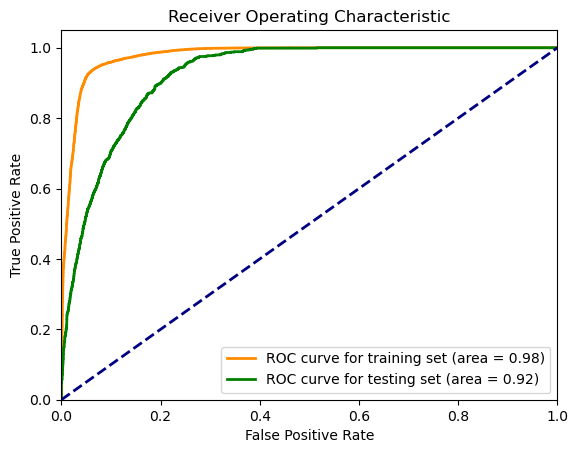

In [24]:
plt.figure()
lw = 2
plt.plot(fpr_train, tpr_train, color='darkorange', lw=lw, label='ROC curve for training set (area = %0.2f)' % roc_auc_train)
plt.plot(fpr_test, tpr_test, color='green', lw=lw, label='ROC curve for testing set (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

#### XGBoost:
* For the training dataset, the AUC is 1.0, which means that the model separates the classes in the training data perfectly.
* For the test dataset, the AUC is 0.97, which is also a very good result, meaning that the model separates the classes in the test data very well.

#### Logistic Regression:
* For the training dataset, the AUC is 0.98, which is a very good result, meaning that the model separates the classes in the training data very well.
* For the test dataset, the AUC is 0.92, which is also a good result but lower than for XGBoost. This means that the model separates classes well in the test data, but not as well as XGBoost.

CONCLUSION: Based on the AUC metric, the XGBoost model appears to be preferred as it provides higher class separation ability on both training and test data. However, training and optimizing xgboost took much longer than with Logistic Regression.